In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sys
sys.path.insert(0, '/Users/alvaro.corrales.canoibm.com/Documents/Scripts/Tobit/') # import tobit custom library from wherever we've got it


### Data ingestion and exploraiton

In [2]:
df = pd.read_csv('rides_data.csv')
df.head()

,driver_id,date,rides_completed,earnings,hours_worked,earnings_hour
0,1.0,2021-06-16,14.0,378.0,6.19,61.066236
1,1.0,2021-06-17,20.0,608.0,8.07,75.340768
2,1.0,2021-06-18,19.0,521.0,8.67,60.092272
3,1.0,2021-06-19,13.0,350.0,7.48,46.791444
4,1.0,2021-06-20,31.0,920.0,11.24,81.850534


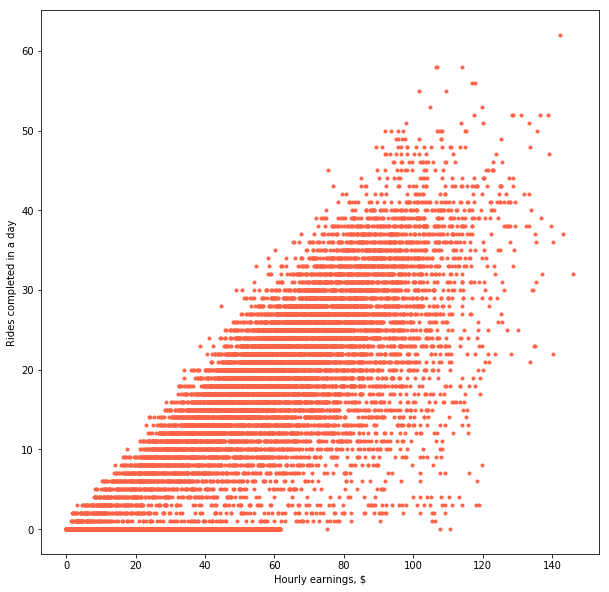

In [3]:
# Single scatter plot of rides per day as a function of hourly earnings
fig, ax = plt.subplots(1, 1, figsize=(10,10))
colour = 'tomato'
marker = '.'

ax.scatter(df['earnings_hour'], df['rides_completed'], c = colour, marker = marker)
ax.set_ylabel('Rides completed in a day')
ax.set_xlabel('Hourly earnings, $')

plt.show()

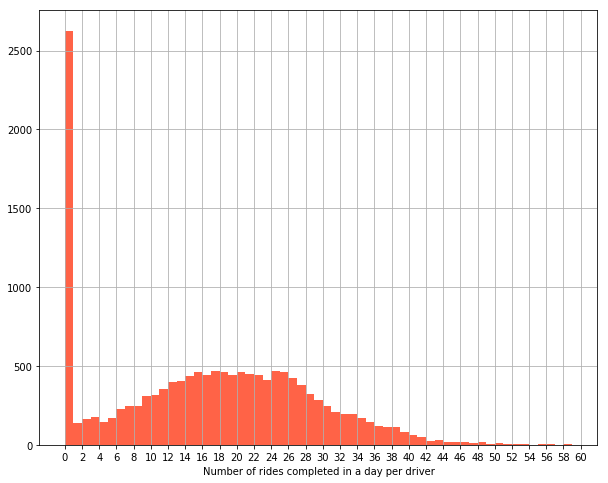

In [4]:
# Single histogram of rides per day
fig, ax = plt.subplots(1, 1, figsize=(10,8))
colour = 'tomato'

ax.hist(df['rides_completed'], bins = range(0,60), color = colour)
ax.set_xticks(range(0, 62, 2))
ax.grid(True)
ax.set_xlabel('Number of rides completed in a day per driver')
plt.show()

### Standard linear (OLS) model

In [5]:
X = df['earnings_hour'].values.reshape(-1, 1)
y = df['rides_completed'].values

In [6]:
lm = LinearRegression()
lm.fit(X, y)
df['fitted_values'] = lm.predict(X)

### Tobit model

In [7]:
import tobit

X_df = pd.DataFrame(data = [np.ones_like(df['earnings_hour']), df['earnings_hour']]).T
cens = ((df['earnings_hour']==0) * -1).reset_index(drop=True)

tb = tobit.TobitModel(fit_intercept=False)

tb.fit(X_df, df['rides_completed'].reset_index(drop = True),cens=cens)
df['fitted_values_tobit'] = tb.predict(X_df)


In [8]:
# Print coefficients
print('Tobit coefficient:', tb.coef_[1])
print('Standard OLS coefficient:', float(lm.coef_))

Tobit coefficient: 0.34840096110120145
Standard OLS coefficient: 0.32702154424547036


### Plot fitted values

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


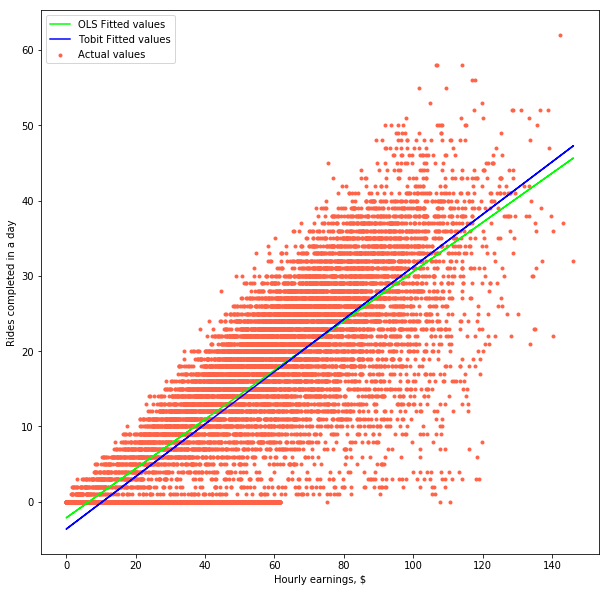

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
colour = 'tomato'
marker = '.'

ax.scatter(df['earnings_hour'], df['rides_completed'], c = colour, marker = marker)
ax.set_ylabel('Rides completed in a day')
ax.set_xlabel('Hourly earnings, $')
ax.plot(df['earnings_hour'], df['fitted_values'], c = 'lime')
ax.plot(df['earnings_hour'], df['fitted_values_tobit'], c = 'blue')
ax.legend(['OLS Fitted values', 'Tobit Fitted values', 'Actual values'])


plt.show()

### Marginal effects

In [10]:
print("Marginal effect for an hourly rate of $10:", tb.margins((1, 10), k = 1))
print("Marginal effect for an hourly rate of $40:", tb.margins((1, 40), k = 1))
print("Marginal effect for an hourly rate of $40:", tb.margins((1, 100), k = 1))

Marginal effect for an hourly rate of $10: 0.17147822305194965
Marginal effect for an hourly rate of $40: 0.3212373038334263
Marginal effect for an hourly rate of $40: 0.34839792917865153
